# Dynamic Programming

Dynamic Programming refers to a collection of algorithms that can be used to compute optimal policies given a perfect model of the environment as a Markov decision process. While classical DP is of limited use for reinforcement learning nowadays, because of their assumption of a perfect model and great computational expense, they are still the foundation for the understanding of more complex models and are important theoretically.

The key idea of DP is the use of value functions to organize and structure the search for good policies. 

### Grid World

We will use grid world toy example, where each agent can move up, down, left or right within a grid with previously specified rows and columns. Each move results in reward of -1. Top-left and bottom-right corners are terminal states are getting there gives agents the reward of 0. If agent makes a move that is out of bounds of the given grid, the agents stays in place instead and receives reward of -1.

In [1]:
import numpy as np

class GridWorld:
   def __init__(self, rows=4, cols=4):
      self.rows = rows
      self.cols = cols
      self.state = None
      self.is_done = False
      self.available_actions = ['up', 'down', 'left', 'right']
      self.a2i = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
      self.i2a = {0: 'up', 1: 'down', 2: 'left', 3: 'right'}
      self.reset()
         
   def reset(self):
      self.grid = np.zeros((self.rows, self.cols))
      for i in range(self.rows):
         self.grid[i, :] = np.arange(self.cols)+self.cols*i
      
      self.state = np.random.randint(1, self.rows*self.cols)
      self.n_states = self.rows*self.cols
      self.is_done = False
      
   def step(self, action, state=None, look_ahead=False):
      if self.is_done:
         print('Agent reached terminal state in the previous move, please reset the environment!')
         return
      if state is None: state = self.state
      
      action = action.lower()
      if action not in self.available_actions:
         raise 'Invalid action'
      
      terminal = False
      reward = -1
      if action == 'up':
         new_state = state - self.rows if state not in self.grid[0, :] else state
      elif action == 'down':
         new_state = state + self.rows if state not in self.grid[self.rows-1, :] else state
      elif action == 'right':
         new_state = state + 1 if state not in self.grid[:, self.cols-1] else state
      elif action == 'left':
         new_state = state - 1 if state not in self.grid[:, 0] else state
         
      if self.is_terminal(new_state):
         terminal = True
         reward = -1

      if not look_ahead:
         self.state = new_state
         self.is_done = terminal
         
      return new_state, reward, terminal
   
   def is_terminal(self, state):
      return state == 0 or state == (self.n_states-1)
   
   def __repr__(self):
      vis = np.zeros_like(self.grid)
      row = self.state // self.rows
      col = self.state % self.cols
      vis[row][col] = 1
      return str(vis)

In [2]:
g = GridWorld()
g

[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [3]:
g.step('down')

(10, -1, False)

In [4]:
g

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

### Policy Evaluation

First, let's look into ways of computing the state-value function $v_\pi$ for an arbitrary policy $\pi$. We know that:

$$v_\pi(s)=E_\pi [G_t|S_t=s]=\sum_a \pi(a|s)\sum_{s',r}p(s',r|s,a)[r+\gamma v_\pi (s')]$$

where $\pi(a|s)$ is the probability of taking action $a$ in state $s$ under policy $\pi$. The expectations $E_\pi$ are conditional on $\pi$, thus the subscript.

We can use *iterative policy evaluation* which applies the same operation to each state $s$: it replaces the old value of $s$ with new value obtained form the old values of the successor states of $s$, and the expected immediate rewards, along all the one-step transitions possible under the policy being evaluated. This is called *expected update* - each iteration of iterative policy evalution updates the value of every state once to produce the new approximate value function $v_{k+1}$. The updates are called *expected*, because they are based on expectation over all possible next states rather than on a sample next state. 

<img src='resources/iterative-policy-evaluation.JPG' />

In [5]:
import numpy as np

def ipe(env, policy, theta=1e-5, gamma=1, n_steps=100, print_every=False):
   '''
   Iterative Policy Evaluation
   Inputs:
    - pi (dict): policy to be evaluated
    - theta (float): threshold > 0 determining accuracy of estimation
    - gamma (float): discount factor how to measure expected rewards received in far future
    - n_steps (int): for how many steps to iterate through all states
    - print_every (list): whether to print the curret value table estimation
   '''
   V = np.zeros(env.n_states)
   i_step = 0.
   while True and i_step < n_steps:
      delta = 0.
      V_tmp = V.copy()
      
      # Calculate
      for s in range(1, env.n_states-1):
         v = 0.
         for a in env.available_actions:
            new_s, r, done = env.step(a, state=s, look_ahead=True)
            v += policy[s][a] * (r + gamma*V[new_s])
         delta = max(delta, np.abs(v-V_tmp[s]))
         V_tmp[s] = v
         #if delta < theta: break
      
      # Print value estimation table
      if print_every:
         if i_step in print_every:
            print(f'Iteration: {i_step}')
            print(np.round(V.reshape(env.rows, env.cols), 1))
            print('-'*50 + '\n')
            
      V = V_tmp.copy()
      i_step += 1
      
   return V

In [6]:
random_policy = {key: {val: 0.25 for val in ['up', 'down', 'left', 'right']}for key in range(0, 16)}

In [7]:
g.reset()
V = ipe(g, random_policy, n_steps=100, print_every=[0, 1, 2, 3, 10, 99])

Iteration: 0.0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
--------------------------------------------------

Iteration: 1.0
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]
--------------------------------------------------

Iteration: 2.0
[[ 0.  -1.8 -2.  -2. ]
 [-1.8 -2.  -2.  -2. ]
 [-2.  -2.  -2.  -1.8]
 [-2.  -2.  -1.8  0. ]]
--------------------------------------------------

Iteration: 3.0
[[ 0.  -2.4 -2.9 -3. ]
 [-2.4 -2.9 -3.  -2.9]
 [-2.9 -3.  -2.9 -2.4]
 [-3.  -2.9 -2.4  0. ]]
--------------------------------------------------

Iteration: 10.0
[[ 0.  -6.1 -8.4 -9. ]
 [-6.1 -7.7 -8.4 -8.4]
 [-8.4 -8.4 -7.7 -6.1]
 [-9.  -8.4 -6.1  0. ]]
--------------------------------------------------

Iteration: 99.0
[[  0.  -13.9 -19.9 -21.9]
 [-13.9 -17.9 -19.9 -19.9]
 [-19.9 -19.9 -17.9 -13.9]
 [-21.9 -19.9 -13.9   0. ]]
--------------------------------------------------



### Policy Improvement

One of the reasons for computing the value function is to find better policies. We know how good it is to follow the current policy from which the value function was estimated in the first place, but is it better or worse to change to the new policy? One way to answer that is to select $a$ in $s$ and follow the existing policy:

$$q_\pi(s,a)=\sum_{s',r}p(s',r|s,a)[r+\gamma v_\pi (s')]$$

The criteria whether new action is better is dependent whether it is greater than or less than $v_\pi(s)$. This check is called *policy improvement theorem*:

$$q_\pi(s,\pi'(s)) \geq v_\pi(s)$$

If the above equation is true, then $\pi'$ must be as good as, or better than, $\pi$ - it must obtain greater or equal expected return from all states $s \in S$

$$v_{\pi'}(s) \geq v_\pi(s)$$

Thus, knowing a policy and its value function, we can easily evaluate a change in he policy at a single state to a particular action. We can extend this to consider changes at *all* states and to *all* possible actions, selecting at each state the action that appears best according to $q_\pi(s)$

$$\pi'(s)=argmax_a q_\pi(s,a)=argmax_a \sum_{s',r}p(s',r|s,a)[r+\gamma v_\pi(s')]$$

This *greedy* policy takes action that looks best in short term - after one step of lookahead - according to $v$. By construction, if meets the conditions of the policy improvement theorem and thus must be as good (or better) than the original policy.

We can iterate through policies by improving the first policy $\pi$ using $v_\pi$, which yields $\pi'$. Then we can compute $v_{\pi'}$ and improve it again to yield even better $\pi''$ until we reach convergance at optimal $v_*$ and $\pi_*$.

<img src='./resources/policy-iteration.JPG' />

In [8]:
def ipi(env, policy, V, gamma=1.):
   '''Iterative Policy Improvement'''
   policy_stable = True
   for s in range(1, env.n_states-1):
      old_action = np.argmax(list(policy[s].values()))
      
      action_eval = []
      for a in env.available_actions:
         new_s, r, done = env.step(a, state=s, look_ahead=True)
         action_eval.append(r + gamma*V[new_s])
      best_action = np.argmax(action_eval)
      
      if old_action != best_action:
         policy_stable = False
      
      for a in env.available_actions:
         if env.a2i[a] == best_action: 
            policy[s][a] = 1.
         else: 
            policy[s][a] = 0.

   return policy, policy_stable

In [9]:
def policy_iteration(env):
   # Start with random policy
   policy = {key: {val: 1./len(env.available_actions) for val in env.available_actions} for key in range(0, env.n_states)}
   done = False
   
   while not done:
      # Policy Evaluation
      V = ipe(env, policy, theta=1e-5, gamma=1, n_steps=100, print_every=False)

      # Policy Improvement
      policy, done = ipi(env, policy, V)

   return policy, V

In [10]:
g.reset()
policy, V = policy_iteration(g)

In [11]:
policy

{0: {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25},
 1: {'up': 0.0, 'down': 0.0, 'left': 1.0, 'right': 0.0},
 2: {'up': 0.0, 'down': 0.0, 'left': 1.0, 'right': 0.0},
 3: {'up': 0.0, 'down': 1.0, 'left': 0.0, 'right': 0.0},
 4: {'up': 1.0, 'down': 0.0, 'left': 0.0, 'right': 0.0},
 5: {'up': 1.0, 'down': 0.0, 'left': 0.0, 'right': 0.0},
 6: {'up': 1.0, 'down': 0.0, 'left': 0.0, 'right': 0.0},
 7: {'up': 0.0, 'down': 1.0, 'left': 0.0, 'right': 0.0},
 8: {'up': 1.0, 'down': 0.0, 'left': 0.0, 'right': 0.0},
 9: {'up': 1.0, 'down': 0.0, 'left': 0.0, 'right': 0.0},
 10: {'up': 0.0, 'down': 1.0, 'left': 0.0, 'right': 0.0},
 11: {'up': 0.0, 'down': 1.0, 'left': 0.0, 'right': 0.0},
 12: {'up': 1.0, 'down': 0.0, 'left': 0.0, 'right': 0.0},
 13: {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 1.0},
 14: {'up': 0.0, 'down': 0.0, 'left': 0.0, 'right': 1.0},
 15: {'up': 0.25, 'down': 0.25, 'left': 0.25, 'right': 0.25}}

In [12]:
V.reshape(g.rows, g.cols)

array([[ 0., -1., -2., -3.],
       [-1., -2., -3., -2.],
       [-2., -3., -2., -1.],
       [-3., -2., -1.,  0.]])

In [15]:
pick_best_action = lambda env, policy, state: g.i2a[np.argmax(list(policy[state].values()))]
optimal_policy = np.array([pick_best_action(g, policy, s) for s in range(g.n_states)]).reshape(g.rows, g.cols)
print(optimal_policy)

[['up' 'left' 'left' 'down']
 ['up' 'up' 'up' 'down']
 ['up' 'up' 'down' 'down']
 ['up' 'right' 'right' 'up']]


### Value Iteration

Problem with policy evaluation is that at each iteration we need to evaluate new policy, which requires multiple sweeps through the state set. We can, in fact, truncate policy evaluation without losing the covergence guarantees of policy iteration. One such way to achieve this is to stop policy evaluation after just one sweep - this algorithm is called *value iteration*, which combines the policy improvement and truncated policy evaluation steps.

<img src='./resources/value-iteration.JPG' />

In [16]:
def value_iteration(env, theta=1e-3, gamma=1., grid_world=True):
   V = np.zeros(env.n_states)
   while True:
      delta = 0
      policy = {key: {val: 0. for val in env.available_actions} for key in range(0, env.n_states)}
      V_tmp = V.copy()
      for s in range(1, env.n_states-1):
         vs = []
         for a in env.available_actions:
            # Lookahead and calculate given action expected returns
            new_s, r, done = env.step(a, state=s, look_ahead=True)
            vs.append(r + gamma*V[new_s])            
            
         # Update value function
         V_tmp[s] = max(vs)
         delta = max(delta, abs(V[s] - V_tmp[s]))
         # Update policy
         best_action = np.argmax(vs)
         if grid_world:
            policy[s][env.i2a[best_action]] = 1.
         else:
            policy[s][best_action] = 1.
         
      V = V_tmp.copy()
      if delta < 1e-5: break
      
   return policy, V

In [17]:
g = GridWorld(4)
policy, V = value_iteration(g)

In [18]:
V.reshape(g.rows, g.cols)

array([[ 0., -1., -2., -3.],
       [-1., -2., -3., -2.],
       [-2., -3., -2., -1.],
       [-3., -2., -1.,  0.]])

In [19]:
pick_best_action = lambda env, policy, state: g.i2a[np.argmax(list(policy[state].values()))]
optimal_policy = np.array([pick_best_action(g, policy, s) for s in range(g.n_states)]).reshape(g.rows, g.cols)
print(optimal_policy)

[['up' 'left' 'left' 'down']
 ['up' 'up' 'up' 'down']
 ['up' 'up' 'down' 'down']
 ['up' 'right' 'right' 'up']]


### Gambler's Problem

In [20]:
class GamblersProblem():
   def __init__(self, p_head=0.4, win_amount=100):
      self.n_states = win_amount
      self.p_head = p_head
      self.state = 1
      self.states = np.arange(1, self.n_states)
      self.actions = np.arange(0, self.n_states)
      self.rewards = np.zeros(self.n_states+1)
      self.rewards[100] = 1
      
   def is_win(self, new_state):
      return new_state >= self.n_states
   
   def is_lose(self, new_state):
      return new_state <= 0
   
   def step(self, action, state=None, look_ahead=False):
      reward = 0
      done = False
      if state is None: state = self.state
         
      flip = np.random.random()
      if flip <= self.p_head:
         new_state = state + action
      else:
         new_state = state - action
         
      if self.is_win(new_state):
         done = True
         reward = 1
      if self.is_lose(new_state):
         done = True
        
      if not look_ahead:
         self.state = new_state
         
      return new_state, reward, done
   
   def calculate_expected_rewards(self, policy, V, state, gamma):
      A = np.zeros(max(policy[state].keys())+1)
      for a in policy[state].keys():
         win = self.p_head * (self.rewards[state+a] + gamma*V[state+a])
         lose = (1-self.p_head) * (self.rewards[state-a] + gamma*V[state-a])
         A[a] = win + lose
      return A

In [55]:
env = GamblersProblem(p_head=0.55)

In [56]:
def gamblers_value_iteration(env, n_steps, gamma=1.):
   V = np.zeros(env.n_states+1)
   gamma = 1.
   for i in range(n_steps):
      # Create dummy policy to hold best actions given state 
      policy = {key: {val: 0. for val in np.arange(1, min(key, 100-key)+1)} for key in range(0, env.n_states)}
      V_tmp = V.copy()
      delta = 0
      for s in range(1, env.n_states):
         # Get estimate expected return per action
         A = env.calculate_expected_rewards(policy, V, s, gamma)
         # Update value function
         V_tmp[s] = max(A)
         delta = max(delta, abs(V[s] - V_tmp[s]))
         # Update policy
         best_action = np.argmax(A)
         policy[s][best_action] = 1.

      V = V_tmp.copy()
      if delta < 1e-5: break
         
   return policy, V

In [91]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

def plot_results(p_head):
   env = GamblersProblem(p_head=p_head)
   _, V1 = gamblers_value_iteration(env, 1)
   _, V2 = gamblers_value_iteration(env, 2)
   _, V3 = gamblers_value_iteration(env, 3)
   _, V5 = gamblers_value_iteration(env, 5)
   policy, V100 = gamblers_value_iteration(env, 100)
   
   fig, axs = plt.subplots(2, 1, figsize=(8, 10))

   axs[0].plot(V1, label='sweep 1')
   axs[0].plot(V2, label='sweep 2')
   axs[0].plot(V3, label='sweep 3')
   axs[0].plot(V5, label='sweep 5')
   axs[0].plot(V100, label='sweep 100')

   axs[0].set_xlim(0, 99)
   axs[0].set_xticks([1, 25, 50, 75, 99])
   axs[0].set_xlabel('Capital')
   axs[0].set_ylabel('Value estimates')
   axs[0].legend()
   
   heights = [np.argmax(list(policy[s].values())) for s in range(1, env.n_states-1)]
   axs[1].bar(np.arange(1, 99), height=heights)
   axs[1].set_xlim(0, 99)
   axs[1].set_xticks([1, 25, 50, 75, 99])
   axs[1].set_xlabel('Capital')
   axs[1].set_ylabel('Final Policy (stake)')
   
   plt.show()

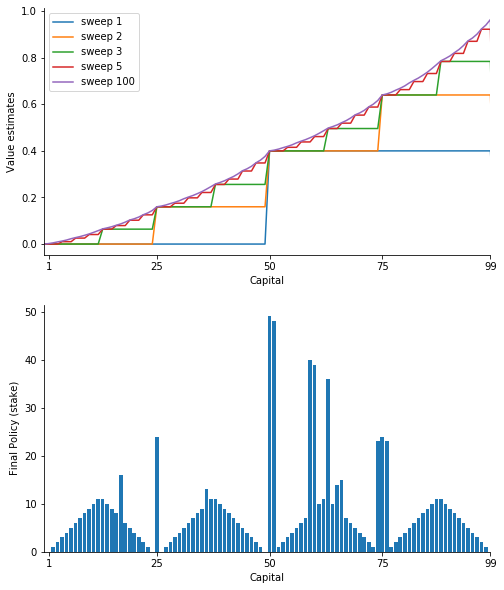

In [92]:
plot_results(p_head=0.4)

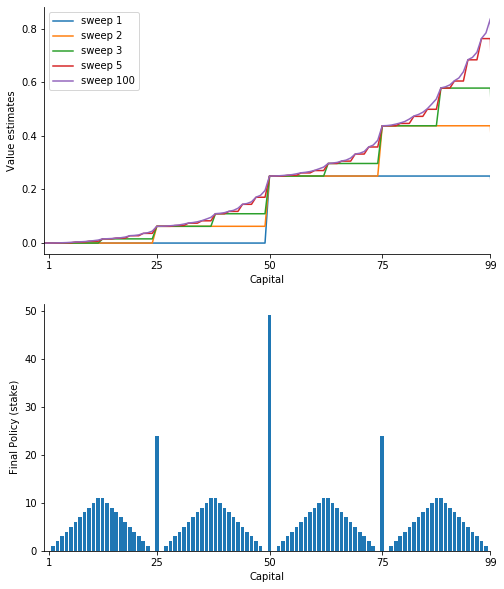

In [93]:
plot_results(p_head=0.25)

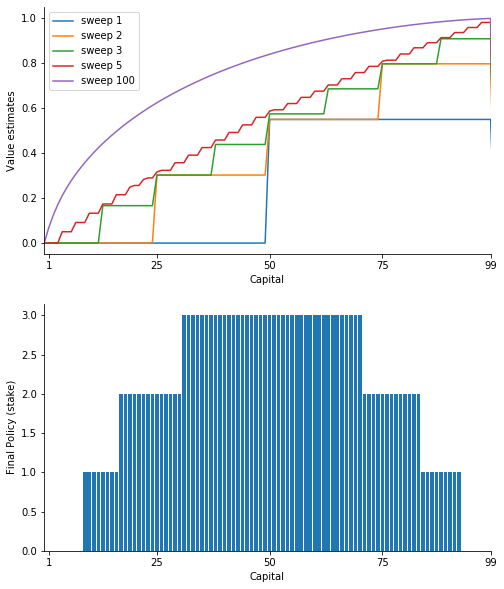

In [94]:
plot_results(p_head=0.55)

### Asynchronous Dynamic Programming

DP methods involve operations over the entire state set of the MDP, which is massive drawback as this is very computationaly expensive and takes time. *Asynchronous* DP algorithms are in-place iterative DP algorithms that are not organized in terms of systematic sweeps of the state set - instead they update the values of the states in any order whatsoever, using any values of other states happen to be available. This allows us to focus on the states that actually *need* an update as they are more relevant to the agent than others - this kind of technique is very important in reinforcement learning. Also, ADP makes it possible to solve MDP at the same time as an agent is actually experiencing the MDP. The agent experience can be used to determine the states to which the DP algorithm applies its updates, while the latest value and policy influence agent's decision making process in real time. 

### Generalized Policy Iteration

Policy iteration consists of two simultaneous, interacting processes - one that makes the value function consistent with the current policy (policy evaluation) and the other that makes the policy greedy with respect to the current value function (policy improvement). Value iteration combines those two processes into one. Asynchronous DP interleaves evaluation and improvement at an even finer grain. 

The term *Generalized Policy Iteration* (GPI) refers to the general idea of letting policy-evaluation and policy-improvement processes interact, independent of the granularity and other details of the two processes. Almost all reinforcement learning methods are described as GPI - that is, all have identifiable policies and value functions, with the policy always being improved with respect to the value function and the value function always being driven toward the value function for the policy:

<img src='./resources/gpi-processes.JPG' />

If both evaluation process and the improvement process stabilize (no longer produce changes), then the value function and policy must be optimal. The value function stabilizes only when it is consistent with the current policy, and the policy stabilizes only when it is greedy with respect to the current value function. Thus, both processes stabilize only when a policy has been foud that is greedy with respect to its own evaluation function. 

Evaluation and improvement processes in GPI can be viewed as both competing and cooperating. Each process drives the value function or policy toward one of the lines representing a solution to one of the two goals.

<img src='./resources/gpi-convergance.JPG' />

All DP methods update estimates of the values of states based on estimates of the values of successor states. That is, they update estimates on the basis of other estimates. This process is called *bootstrapping* and many reinforcement learning algorithm are using it.